# Projet conversion rate - Lise Gnos


In [1]:
!pip install -U imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_absolute_error
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode"
from IPython.display import display

In [4]:
dataset = pd.read_csv('src/conversion_data_train.csv')

In [5]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

**A few observations :**
1. there are outliers for the age since the maximum is at 123.
2. the conversion rate is very low, because the 75%ile value is equal to 0 and the mean is at 0.03. \
Let's do some EDA in order to see the repartition of the parameters.

In [6]:
#remove the age outliers
dataset = dataset.loc[dataset['age']<=80,:]

In [7]:
data_sample = dataset.sample(10000)

In [8]:

# Univariate analysis
# Distribution of each numeric variable
num_features = ['age', 'total_pages_visited']
for f in num_features:
    fig = px.histogram(data_sample, f, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    fig.show()


In [9]:

# Visualize pairwise dependencies
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=1200, width = 1200)
fig.show()


/home/lise/.local/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [10]:
px.histogram(data_sample, 'converted', histnorm = 'probability', height=500, width = 500)

In [11]:
px.histogram(data_sample, 'country', histnorm = 'probability', height=500, width = 500)

In [12]:
px.histogram(data_sample, 'new_user', histnorm = 'probability', height=500, width = 500)

In [13]:
px.histogram(data_sample, 'source', histnorm = 'probability', height=500, width = 500)

The total pages visited seems to be a good parameter for the conversion rate, let's run a baseline model with this parameter.
## Baseline model : simple linear regression ##

In [14]:
features_list = ['total_pages_visited']
target_variable = 'converted'

In [15]:
X = dataset.loc[:, features_list]
Y = dataset.loc[:, target_variable]

In [16]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [17]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_train = featureencoder.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

#The target is already 0/1 encoded and there is no missing value in the dataset.

Encoding categorical features and standardizing numerical features...
...Done
[[-0.26099836]
 [ 0.03829244]
 [-0.56028917]
 [-1.15887077]
 [ 0.33758325]]


In [18]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [19]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [20]:
print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 2.73190968]
 [ 0.03829244]
 [-0.26099836]
 [ 0.93616485]
 [ 0.93616485]]


In [21]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[1 0 0 ... 0 0 0]



In [22]:
print("accuracy on train set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

accuracy on train set :  0.9829728252381696
accuracy on test set :  0.9828519221308595
f1-score on train set :  0.6950136373172948
f1-score on test set :  0.6961394769613949


The model has an accuracy of about 98%. We can compare the value to :

In [23]:
dataset['converted'].value_counts()

0    275400
1      9178
Name: converted, dtype: int64

In [24]:
rate_unconverted = dataset['converted'].value_counts()[0] / len(dataset)
rate_unconverted

0.9677487367259592

If the model had predicted 'not converted' for all the observations, the score would have been 96,7%. \
It means that the model performs better than that. However, let's try to improve it and we will use the f1-score to have a better metric.

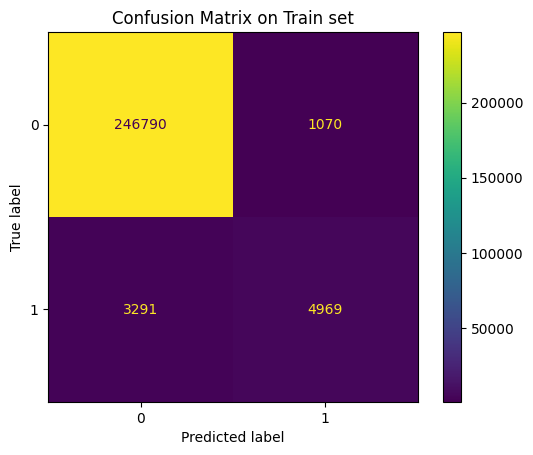

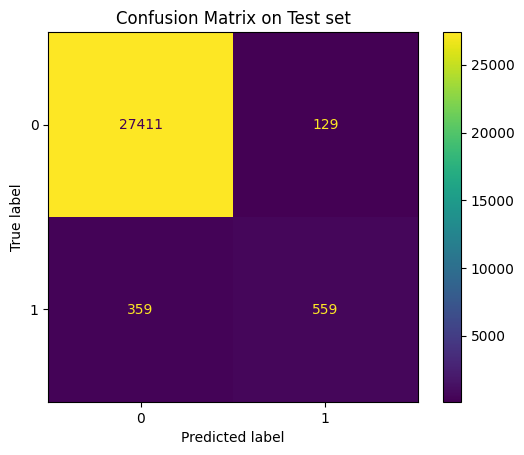

In [25]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

We can see that the model tends to predict more often false unconverted compared to false converted. This may be due to the very unbalanced repartition of 0 and 1 in the dataset. \
First, we are going to do some more preprocessings and run the model. \
New preprocessings will be :
1. Put UK and Germany in a new 'Europe' value to improve the representativity of these countries in the dataset.
2. Remove some unconverted observations from the dataset to have a better balance between converted / unconverted.

In [26]:
# corriger

## Model 7 : multivariate logistic regression with Smote Tomek Links and penalty and bagging

I create a new feature 'agepage' which is total_pages_visited / age. Indeed, according to the bivariate analysis, it seems that the older people visit less pages. So this feature will enlighten the effect : 'agepage' will be higher with younger people and a lot of pages visited.  
I also create the square of 'age' in order to make the model non linear.

In [27]:
dataset['agepage'] = dataset['total_pages_visited']/dataset['age']
dataset['age2'] = dataset['age']*dataset['age']

In [28]:
dataset.head()

,country,age,new_user,source,total_pages_visited,converted,agepage,age2
0,China,22,1,Direct,2,0,0.090909,484
1,UK,21,1,Ads,3,0,0.142857,441
2,Germany,20,0,Seo,14,1,0.700000,400
3,US,23,1,Seo,3,0,0.130435,529
4,US,28,1,Direct,3,0,0.107143,784


In [29]:
features_list1 = ['country', 'age', 'new_user', 'source', 'total_pages_visited', 'agepage', 'age2']
target_variable1 = target_variable

In [30]:
X1 = dataset.loc[:, features_list1]
Y1 = dataset.loc[:, target_variable1]

In [31]:
numeric_features1 = ['age', 'total_pages_visited', 'agepage', 'age2']
categorical_features1 = ['country', 'new_user', 'source']

In [32]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train1, X_test1, Y_train01, Y_test01 = train_test_split(X1, Y1, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [33]:
# Create pipeline for numeric features
numeric_transformer1 = StandardScaler()
# Create pipeline for categorical features
categorical_transformer1 = OneHotEncoder(drop='first')
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features1),
        ('cat', categorical_transformer1, categorical_features1)
    ])

# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

X_train01 = preprocessor1.fit_transform(X_train1)
print("...Done")
print(X_train01[0:5,:])

print("Encoding categorical features and standardizing numerical features...")

X_test01 = preprocessor1.transform(X_test1)
print("...Done")
print(X_test01[0:5,:])

#The target is already 0/1 encoded and there is no missing value in the dataset.

Encoding categorical features and standardizing numerical features...
...Done
[[-1.51987065 -0.26099836  0.35772278 -1.23985271  0.          0.
   1.          0.          0.          1.        ]
 [ 2.2307148   0.03829244 -0.51665289  2.55626306  0.          0.
   0.          0.          0.          1.        ]
 [ 1.86775492 -0.56028917 -0.78456045  2.03537091  0.          0.
   0.          1.          0.          1.        ]
 [-1.51987065 -1.15887077 -0.8548548  -1.23985271  0.          0.
   1.          0.          0.          0.        ]
 [-1.03592414  0.33758325  0.72517054 -0.94742203  0.          0.
   1.          1.          0.          0.        ]]
Encoding categorical features and standardizing numerical features...
...Done
[[-0.79395089  2.73190968  2.98497421 -0.77927439  0.          0.
   0.          1.          0.          0.        ]
 [ 0.53690202  0.03829244 -0.21969511  0.40689755  0.          0.
   1.          0.          1.          0.        ]
 [-0.18901775 -0.2609983

In [34]:
# Perform Smote Tomek Links
#resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
smtom = SMOTETomek(sampling_strategy = 0.0336, random_state = 0) # the initial ratio of minority class / majority class is 0.0333
X_train1, Y_train1 = smtom.fit_resample(X_train01, Y_train01)


# Perform grid search
print("Bagging...")
logistic_regression = LogisticRegression(class_weight={0:1,1:1.2}, penalty = 'l2', C=0.12, max_iter = 1000) # max_iter changed because of convergence warning
classifier1 = BaggingClassifier(logistic_regression, n_estimators = 20)
'''
# Grid of values to be tested
params = {
    'n_estimators': [20] # n_estimators is a hyperparameter of the ensemble method
}
#'n_estimators': [5, 10, 20, 30]
print(params)
classifier1 = GridSearchCV(model, param_grid = params, cv = 10, verbose = 2) # cv : the number of folds to be used for CV
'''
classifier1.fit(X_train1, Y_train1)
print("...Done.")
#print("Best hyperparameters : ", classifier1.best_params_)
#print("Best validation accuracy : ", classifier1.best_score_)
print()


Bagging...
...Done.



In [35]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred1 = classifier1.predict(X_train1)
print("...Done.")
print(Y_train_pred1)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred1 = classifier1.predict(X_test01)
print("...Done.")
print(Y_test_pred1)
print()

print("accuracy on train set : ", accuracy_score(Y_train1, Y_train_pred1))
print("accuracy on test set : ", accuracy_score(Y_test01, Y_test_pred1))

print("f1-score on train set : ", f1_score(Y_train1, Y_train_pred1))
print("f1-score on test set : ", f1_score(Y_test01, Y_test_pred1))

Predictions on training set...
...Done.
[0 0 0 ... 1 1 1]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

accuracy on train set :  0.9863242656419628
accuracy on test set :  0.9863307330100499
f1-score on train set :  0.7706914614981666
f1-score on test set :  0.7705014749262535


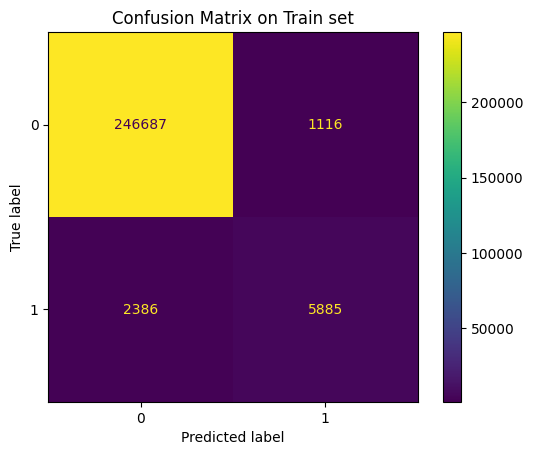

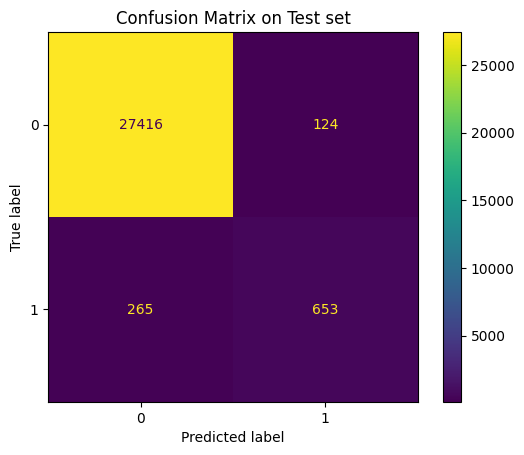

In [36]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier1, X_train1, Y_train1, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier1, X_test01, Y_test01, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [37]:

# Concatenate our train and test set to train your best classifier on all data with labels

X1_fi = np.append(X_train01,X_test01,axis=0)
Y1_fi = np.append(Y_train01,Y_test01)

X1_fi, Y1_fi = smtom.fit_resample(X1_fi, Y1_fi)

classifier1.fit(X1_fi,Y1_fi)


BaggingClassifier(base_estimator=LogisticRegression(C=0.12,
                                                    class_weight={0: 1, 1: 1.2},
                                                    max_iter=1000),
                  n_estimators=20)

In [38]:

# Read data without labels
data_without_labels = pd.read_csv('src/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

#data_without_labels['country'] = data_without_labels['country'].apply(lambda x : 'Europe' if ((x == 'UK') or (x== 'Germany')) else x)
data_without_labels['agepage'] = data_without_labels['total_pages_visited']/data_without_labels['age']
data_without_labels['age2'] = data_without_labels['age']*data_without_labels['age']

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
X_without_labels = data_without_labels.loc[:, features_list1]
print(X_without_labels.head())

# Create pipeline for numeric features
numeric_transformer1 = StandardScaler()
# Create pipeline for categorical features
categorical_transformer1 = OneHotEncoder(drop='first')
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features1),
        ('cat', categorical_transformer1, categorical_features1)
    ])

# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor1.fit_transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])



Prediction set (without labels) : (31620, 5)
  country  age  new_user  source  total_pages_visited   agepage  age2
0      UK   28         0     Seo                   16  0.571429   784
1      UK   22         1  Direct                    5  0.227273   484
2   China   32         1     Seo                    1  0.031250  1024
3      US   32         1     Ads                    6  0.187500  1024
4   China   25         0     Seo                    3  0.120000   625
Encoding categorical features and standardizing numerical features...
...Done
[[-0.31512217  3.33913917  2.89666673 -0.40273379  0.          1.
   0.          0.          0.          1.        ]
 [-1.03657046  0.03888347  0.3948061  -0.94502416  0.          1.
   0.          1.          1.          0.        ]
 [ 0.16584336 -1.16120951 -1.03019235  0.03109852  0.          0.
   0.          1.          0.          1.        ]
 [ 0.16584336  0.33890671  0.10567598  0.03109852  0.          0.
   1.          1.          0.          0

In [39]:

# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier1.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('src/conversion_data_test_predictions_Lise-model11.csv', index=False)
